# Juggling RL project

## Install dependencies

In [1]:
#!pip install gymnasium
#!pip install keras-rl
#!pip install mediapy
#!pip install mujoco

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import gymnasium as gym
from gymnasium import spaces

## Import model

<_MjModelBodyViews
  dofadr: array([3], dtype=int32)
  dofnum: array([6], dtype=int32)
  geomadr: array([33], dtype=int32)
  geomnum: array([1], dtype=int32)
  id: 7
  inertia: array([5.36165146e-06, 5.36165146e-06, 5.36165146e-06])
  invweight0: array([2.98415518e+01, 1.86509699e+05])
  ipos: array([0., 0., 0.])
  iquat: array([1., 0., 0., 0.])
  jntadr: array([3], dtype=int32)
  jntnum: array([1], dtype=int32)
  mass: array([0.03351032])
  mocapid: array([-1], dtype=int32)
  name: 'Ball1'
  parentid: array([0], dtype=int32)
  pos: array([0.5, 0.5, 1. ])
  quat: array([1., 0., 0., 0.])
  rootid: array([7], dtype=int32)
  sameframe: array([1], dtype=uint8)
  simple: array([1], dtype=uint8)
  subtreemass: array([0.03351032])
  user: array([], dtype=float64)
  weldid: array([7], dtype=int32)
>
[0. 0. 0.]
[ 0.   0.  -1.9]


""

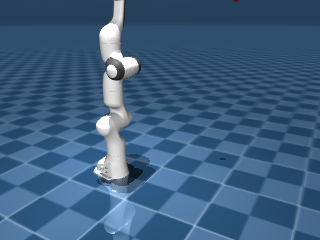

In [3]:
# Make model and data
model = mujoco.MjModel.from_xml_path("./robot/scene.xml")
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [ ]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.ctrl[2]=-1.9
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render().copy()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

## Create the gym environment

We created our environment in envs/Juggling_Env.py.

In [3]:
import custom_gym
env = gym.make('Juggler')

Initialising env


## Create a deep learning model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

## Keras RL agent

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)